In [ ]:
import os
import pandas as pd
import numpy as np
import random
from datasets import load_dataset, DownloadMode, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, GRU, Dense, Bidirectional, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.regularizers import l2


import wandb
from wandb.integration.keras import WandbMetricsLogger


In [70]:
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))

if gpus:
    print("GPU(s) detected:")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("No GPU detected. Running on CPU.")

TensorFlow version: 2.10.0
Num GPUs Available: 0
No GPU detected. Running on CPU.


In [ ]:
#setup random seed and check WD
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

os.chdir("C:/Users/Fuglsang/OneDrive/DS projects/nlp-emotion-classifier") 
print(os.getcwd())

C:\Users\Fuglsang\OneDrive\DS projects\bluesky-emotion-classifier


In [72]:
train_df = pd.read_parquet("data/parquet_files/train.parquet")
val_df = pd.read_parquet("data/parquet_files/validation.parquet")
test_df = pd.read_parquet("data/parquet_files/test.parquet")

print(f"Loaded {len(train_df):,} training rows")
print(f"Loaded {len(val_df):,} validation rows")
print(f"Loaded {len(test_df):,} testing rows")

Loaded 341,366 training rows
Loaded 33,762 validation rows
Loaded 41,681 testing rows


In [73]:
# Sets the vocab size, sequnce length and batch size. Vectorizes the dataframes, and creates train/val/test tf datasets.

MAX_VOCAB = 4640
MAX_SEQ_LEN = 52
BATCH_SIZE = 128
NUM_CLASSES = train_df["label"].nunique()

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_VOCAB,
    output_sequence_length=MAX_SEQ_LEN
)
vectorizer.adapt(train_df["text"])

def df_to_dataset(df, shuffle=False):
    X = vectorizer(df["text"])
    y = df["label"].to_numpy()
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

train_ds = df_to_dataset(train_df, shuffle=True)
val_ds   = df_to_dataset(val_df)
test_ds  = df_to_dataset(test_df)



In [74]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 52), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [75]:
# Compute class weights using sklearn
classes, y_indices  = np.unique(train_df["label"], return_inverse=True)

weights = class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_indices 
)

class_weights = dict(zip(classes, weights))

print("Class weights:", class_weights)

Class weights: {0: 0.5732311019761147, 1: 0.49244666793613423, 2: 2.0104004711425207, 3: 1.2120134066152557, 4: 1.4559917425870952, 5: 4.639890175610287}


In [ ]:
# Creates a first explorative model of simple design, using a bidirection GRU layer and a fairly small embedding dimension
EMBEDDING_DIMENSION = 16

config = {
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "epochs": 20,
    "dropout": 0.5,
    "batch_size": BATCH_SIZE,
    "vocab_size": MAX_VOCAB,
    "max_seq_len": MAX_SEQ_LEN,
    "embedding_dimension": EMBEDDING_DIMENSION,
    'weight_decay': 0,
    'class_weights':True,
    'num_classes': NUM_CLASSES
}


def create_model():
    model = Sequential([
        Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIMENSION, input_length=MAX_SEQ_LEN),
        Bidirectional(GRU(32, dropout=config['dropout'])),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    return model
model = create_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 52, 16)            74240     
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
Total params: 84,230
Trainable params: 84,230
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Initialize wandb run
wandb.init(project="NLP emotion-classifier", name="simple bidirectional GRU", group="GRU", config=config, notes="A simple solution without further hyperparameter tuning")

# Compile model
model = create_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

# Initialize model training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[
        WandbMetricsLogger(),
        early_stop
    ]
)


wandb.run.summary["best_val_loss"] = min(history.history['val_loss'])
wandb.run.summary["best_val_accuracy"] = max(history.history['val_accuracy'])

wandb.finish()

Epoch 1/30
2667/2667 [==============================] - 71s 26ms/step - loss: 0.6567 - accuracy: 0.7604 - val_loss: 0.3156 - val_accuracy: 0.9008
Epoch 2/30
2667/2667 [==============================] - 102s 38ms/step - loss: 0.2836 - accuracy: 0.8955 - val_loss: 0.2155 - val_accuracy: 0.9244
Epoch 3/30
2667/2667 [==============================] - 100s 38ms/step - loss: 0.1894 - accuracy: 0.9220 - val_loss: 0.1595 - val_accuracy: 0.9332
Epoch 4/30
2667/2667 [==============================] - 100s 38ms/step - loss: 0.1561 - accuracy: 0.9304 - val_loss: 0.1525 - val_accuracy: 0.9356
Epoch 5/30
2667/2667 [==============================] - 102s 38ms/step - loss: 0.1430 - accuracy: 0.9337 - val_loss: 0.1399 - val_accuracy: 0.9361
Epoch 6/30
2667/2667 [==============================] - 97s 36ms/step - loss: 0.1368 - accuracy: 0.9346 - val_loss: 0.1385 - val_accuracy: 0.9363
Epoch 7/30
2667/2667 [==============================] - 99s 37ms/step - loss: 0.1310 - accuracy: 0.9357 - val_loss: 0.13

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch/accuracy,▁▆▇███████████████████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▇███████████████████
epoch/val_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_accuracy,0.93821
best_val_loss,0.12353
epoch/accuracy,0.94
epoch/epoch,21
epoch/learning_rate,0.001


Creating the dataset for the final evalutation by

In [80]:
model.save("data/saved_models/simple_gru_model")


INFO:tensorflow:Assets written to: data/saved_models/simple_gru_model\assets


INFO:tensorflow:Assets written to: data/saved_models/simple_gru_model\assets


In [64]:
model = keras.models.load_model("data/saved_models/simple_gru_model")

In [ ]:

# predictions using test ds
y_pred_probs = model.predict(test_ds)
y_pred = y_pred_probs.argmax(axis=1)

# Get the true labels from the test dataframe
y_true = test_df["label"].to_numpy()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

326/326 [==============================] - 8s 24ms/step
Confusion Matrix:
 [[11545    14     5   318   216    21]
 [    7 12910  1008    42     9   131]
 [    2     5  3445     1     1     1]
 [   18    12     1  5478   223     0]
 [    5     2     0    35  4310   419]
 [    0     1     0     0     0  1496]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9972    0.9526    0.9744     12119
           1     0.9974    0.9151    0.9545     14107
           2     0.7726    0.9971    0.8706      3455
           3     0.9326    0.9557    0.9440      5732
           4     0.9057    0.9034    0.9045      4771
           5     0.7234    0.9993    0.8393      1497

    accuracy                         0.9401     41681
   macro avg     0.8881    0.9539    0.9146     41681
weighted avg     0.9495    0.9401    0.9420     41681



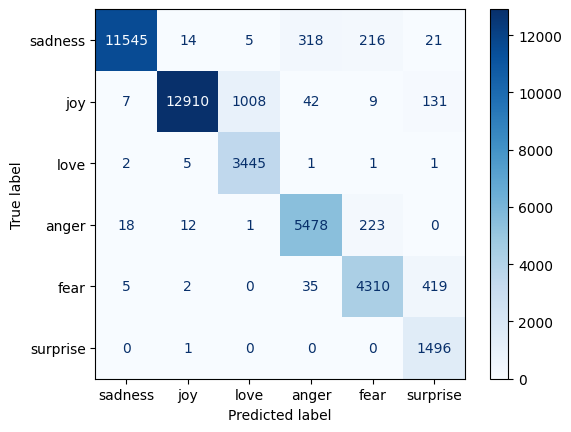

In [82]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
disp.plot(cmap=plt.cm.Blues)
plt.show()
